# Balanced Tree

### Libraries

In [70]:
## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools

# Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import classic

## node colour
color_map = ["steelblue"]

### Supporting Functions

In [71]:
## supporting functions
from support.preprocessing import sort_adjacency, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single, generate_manifold, generate_topol_manifold, generate_topol_manifold
from support.param_generating import generate_param_graph_manifold, generate_param_topol_manifold
from support.latent_space import vis2D, visDistr

## import model
from models.VAE import VAE

## Loading and Preprocessing Network Data

### Loading Network Data

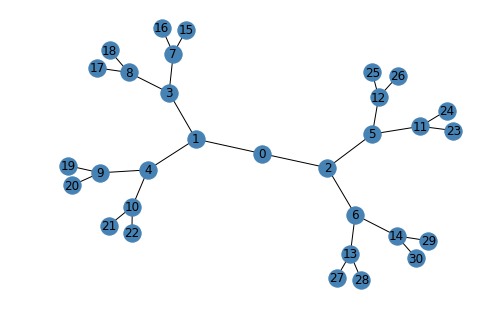

In [3]:
def get_graph(b,h,draw): 

    g = classic.balanced_tree(b, h)

    if draw:
        nx.draw(g, node_color = color_map, with_labels = True)
        plt.show()
    
    return g

g = get_graph(b = 2, h = 4, draw = True)

# Generating Training Data

In [72]:
def generate_data(dataArgs): 
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], diag_offset = dataArgs["diag_offset"])))

    ## Ground Truth Labels ______________________________

    T = list()
    T_array = np.zeros((dataArgs["n_graphs"],2))

    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):

        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            h = dataArgs["h"]         # generate fixed number of nodes n_max
        else:
            h = random.randint(0, dataArgs["h"]) # generate number of nodes n between 1 and n_max and

        b = random.randint(dataArgs["b"][0], dataArgs["b"][1]) 
        
        g = get_graph(b, h, draw = False)
        
        g, a = sort_adjacency(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])


        ## Build Data Arrays___________________________________________________

        G[i] = a_transformed

        t = dict()
        t["b"] = b
        t["h"] = h

        T_array[i] = [b,h]
        T.append(t)



    ## Input and Output Size ___________________________________________________________

    T, input_shape, output_shape = prepare_in_out(T, dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]))
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale parameters in T_array for smoother training
    scaler = MinMaxScaler()
    scaler.fit(T_array)
    T_array = scaler.transform(T_array)
    
    return G,T,T_array,input_shape,output_shape,scaler
    
# n formula = b*(b**h) - 1
dataArgs = {"n_graphs": 20000, "n_max": 32, "h": 4, "b": [2,2], "fix_n": False, "diag_offset": 0, "diag_value": 1, "clip": True}  #"diag_offset" - 1 == full adjacency
G, T, T_array, input_shape, output_shape,scaler = generate_data(dataArgs)


input_shape: (528,) , output_shape: 528


# beta-VAE (MLP, 2D_Conv)

## Build and Train Model

In [84]:
# network parameters
modelArgs = {"nn_architecture": "mlp", "param_loss": False, "latent_dim": 1, "growth_param": T_array.shape[1], "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape}
trainArgs = {"beta": 1, "loss": "binary_crossentropy", "weights": "train", "early_stop": 1, "batch_size": 16, "epochs": 50, "data_split": 0.2}

vae = VAE(modelArgs, trainArgs, G, T_array)

models = vae.model 
data = vae.data

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 528)          0                                            
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 128)          67712       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 64)           8256        dense_37[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 1)            65          dense_38[0][0]                   
__________________________________________________________________________________________________
z_log_var 

# Latent Space Analysis

# Encoder

# Iterate through single data dimension and oberseve single latent space dimension  

Mutual Information Gap: 0.5107392452543679


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:331: RuntimeWarning: invalid value encountered in double_scalars


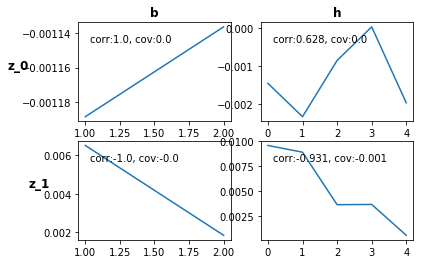

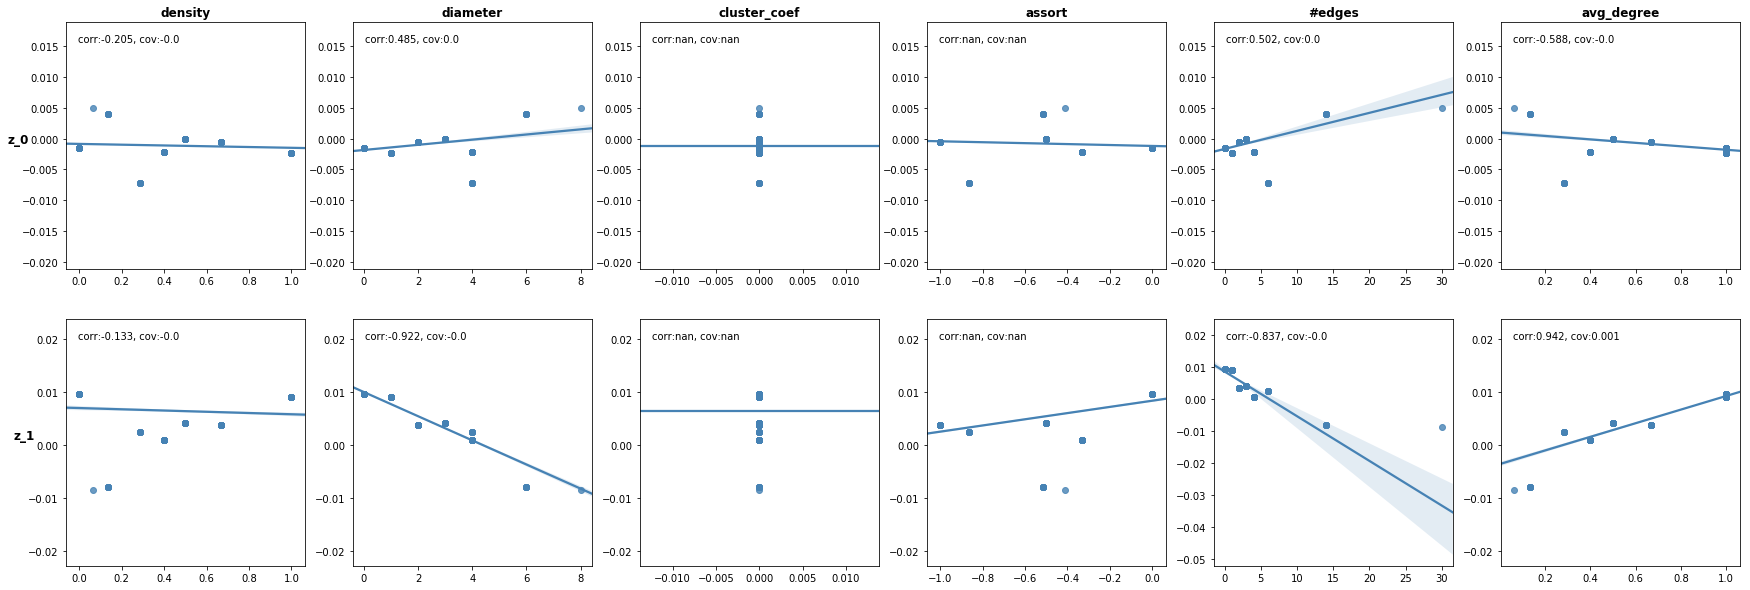

In [151]:
def latent_space_feature_correlation(analyzeArgs, modelArgs, dataArgs, models,batch_size=128,model_name="vae_graph"):

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models
    
    
    
    if analyzeArgs["root_params"] == 1 or modelArgs["latent_dim"] == 1:
        
        ## Generate Graph Data_______________________________
        
        b = dataArgs["b"][1]
        H = np.linspace(0, dataArgs["h"]+1, analyzeArgs["n_config_graphs"], dtype = int)  # array 0.1, 0.2 - 1 / n_config_graphs  
        
        ## growth and topol parameters
        growth_topol_params = ["h","density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]
        
        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth_Topol = np.zeros((analyzeArgs["n_config_graphs"], len(growth_topol_params)))
    
        for i, h in enumerate(H):

            ## Generate Graph Type ______________________________________________

            g = get_graph(int(b), int(h), draw = False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth_Topol[i,0] = h
            Growth_Topol[i,1] = density
            Growth_Topol[i,2] = diameter
            Growth_Topol[i,3] = cluster_coef
            Growth_Topol[i,4] = assort
            Growth_Topol[i,5] = edges
            Growth_Topol[i,6] = avg_degree

  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
        
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            mig = compute_mig(H, np.squeeze(z_mean))
            
        
        ## Visualize Latent Variables x Graph Properties ____________________________
        fig, ax = plt.subplots(nrows= z_mean.shape[1], ncols= Growth_Topol.shape[1], figsize=(20, 10))

        for latent_z, row in enumerate(ax):  
            
            if z_mean.shape[1] == 1:   # only one latent variable
                
                if latent_z == 0:
                    y = z_mean[:,0]
                    x = Growth_Topol[:,latent_z]
                    row.plot(x, y) 

                else:
                    y = z_mean[:,0]
                    x = Growth_Topol[:,latent_z]
                    #row.scatter(x, y) 
                    sns.regplot(x, y, color="steelblue", ax=row)

                    ## plot trend line
                    #x = np.nan_to_num(x)
                    #y = np.nan_to_num(y)

                    #z = np.polyfit(x, y, 1)
                    #p = np.poly1d(z)
                    #row.plot(x,p(x),"steelblue")
                    
                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                row.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')

                    
            else:                     # multiple latent variables
                
                for feature, col in enumerate(row):

                    if feature == 0:
                        y = z_mean[:,latent_z]
                        x = Growth_Topol[:,feature]
                        col.plot(x, y) 

                    else:
                        y = z_mean[:,latent_z]
                        x = Growth_Topol[:,feature]
                        #col.scatter(x, y) 
                        sns.regplot(x, y, color="steelblue", ax=col)

                        ## plot trend line
                        #x = np.nan_to_num(x)
                        #y = np.nan_to_num(y)

                        #z = np.polyfit(x, y, 1)
                        #p = np.poly1d(z)
                        #col.plot(x,p(x),"steelblue")
            
                
                    ## compute correlation and standardized covariance
                    corr = round(pearsonr(x,y)[0],3)
                    cov = round(np.cov(x, y)[0][1]/max(x),3)
                    col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________
        
        if z_mean.shape[1] == 1:   # only one latent variable
                
            cols = [t for t in growth_topol_params]
            
            for axis, col in zip(ax[:,], cols):
                axis.set_title(col, fontweight='bold')
                
        
        if z_mean.shape[1] != 1:   # more than one latent variable
            
            rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
            cols = [t for t in growth_topol_params]

            for axis, row in zip(ax[:,0], rows):
                axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')
            
            for axis, col in zip(ax[0], cols):
                axis.set_title(col, fontweight='bold')

        plt.show()


        

    if analyzeArgs["root_params"] == 2 and modelArgs["latent_dim"] != 1:
        
        ## Generate Graph Data_______________________________
        B = np.linspace(dataArgs["b"][0],dataArgs["b"][1], analyzeArgs["n_config_graphs"], dtype = int)
        H = np.linspace(0,dataArgs["h"], analyzeArgs["n_config_graphs"], dtype = int)  # array 0.1, 0.2 - 1 / n_config_graphs  
        
        ## growth and topol parameters
        growth_params = ["b", "h"]
        topol_params = ["density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]

        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(growth_params)))
        Topol = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(topol_params)))

        ## iterate through topological features
        graph_configs = np.asarray(list(itertools.product(B,H)))
        

        for i, (b,h) in enumerate(graph_configs):

            ## Generate Graph Type ______________________________________________

            g = get_graph(int(b), int(h), draw = False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth[i,0] = int(b)
            Growth[i,1] = int(h)

            Topol[i,0] = density
            Topol[i,1] = diameter
            Topol[i,2] = cluster_coef
            Topol[i,3] = assort
            Topol[i,4] = edges
            Topol[i,5] = avg_degree
  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
                
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            #mi = compute_mi(P, np.squeeze(z_mean))
            mig = compute_mig(Growth, z_mean)
        
        
        ##  Reshape Array according to Parameters  
        z_mean_growth = np.reshape(z_mean, (analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
        Growth = np.reshape(Growth,(analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
            
        ## 1.) Growth Parameters________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        fig, ax = plt.subplots(nrows= z_mean_growth.shape[-1] , ncols= len(growth_params))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                if feature == 0:
                    feature_1 = 1
                if feature == 1:
                    feature_1 = 0

                y = np.mean(z_mean_growth[:,:,latent_z], axis= feature_1)
                x = np.mean(Growth[:,:,feature], axis= feature_1)
                col.plot(x, y)  
                col.set_ylim([np.mean(y) - 3.0, np.mean(y) + 3.0])

                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')


        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean_growth.shape[-1])]
        cols = [t for t in growth_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')



        ## 2.) Graph Topologies________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        ##  Reshape Array according to Parameters  
        #Topol = np.reshape(Topol,(n_config_graphs, n_config_graphs, -1))

        fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= len(topol_params), figsize=(30,10))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                ## toDO: change sorting
                y = z_mean[:,latent_z]
                x = Topol[:,feature]
                sns.regplot(x, y, color="steelblue", ax=col)
                col.set_ylim([np.mean(y) - 3.0, np.mean(y) + 3.0])
                #col.scatter(x, y) 

                # set axes range
                #plt.xlim(-4, 4)
                #plt.ylim(-4, 4)

               # try:
               #     ## plot trend line
               #     x = np.nan_to_num(x)
               #     y = np.nan_to_num(y)

               #     z = np.polyfit(x, y, 1)
               #     p = np.poly1d(z)
               #     col.plot(x,p(x),"steelblue")
               # except:
               #     pass


                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
        cols = [t for t in topol_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')



## PLOT RESULTS ________________________________________

analyzeArgs = {"root_params": 2, "n_config_graphs": 30, "metric": "mig"}
latent_space_feature_correlation(analyzeArgs, modelArgs, dataArgs, models, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize the Latent Space in 2D

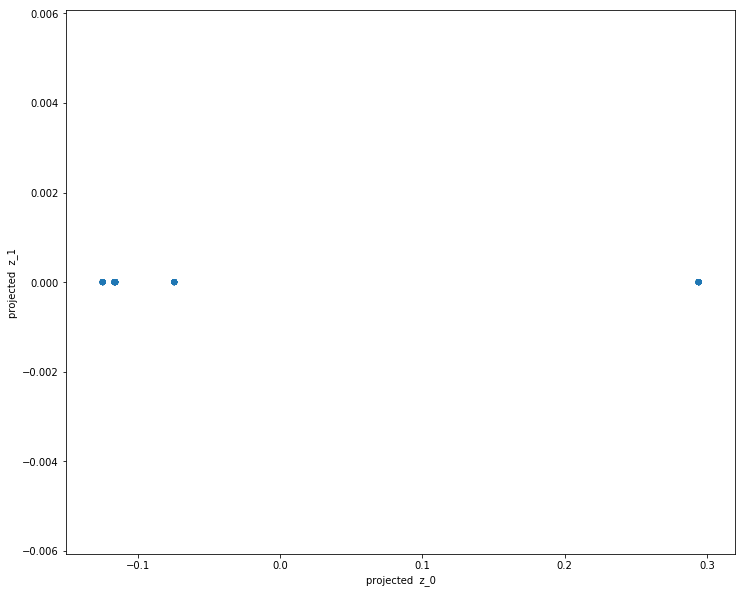

In [142]:
analyzeArgs = {"save_plots": False}
vis2D(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize Latent Generative Distribution

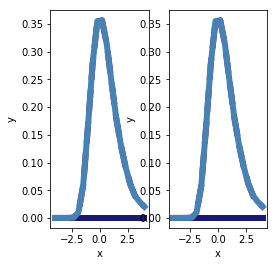

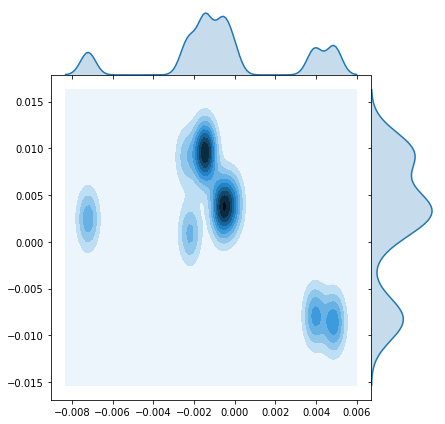

In [152]:
analyzeArgs = {"z": [0,1]}
visDistr(modelArgs, analyzeArgs, models,data,trainArgs["batch_size"])

# Decoder

## Generate a Single Graph Instance

latent dimensions: 2


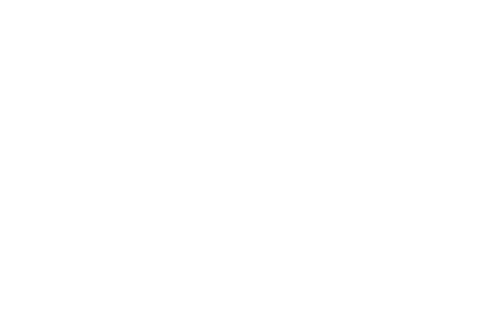

In [153]:
analyzeArgs = {"activations": [0, 0.2], "z": [0,1]}
generate_single(analyzeArgs, modelArgs, dataArgs, models, color_map)

## Generate Interpolated Manifold from Latent Space

In [79]:
from support.preprocessing import reconstruct_adjacency, unpad_matrix

import networkx as nx
import numpy as np

from matplotlib import pylab as plt
import os



## apply decoder and generate data

def generate_single(analyzeArgs, modelArgs, dataArgs, models, color_map):

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models

    print("latent dimensions:", modelArgs["latent_dim"])

    z_sample = np.zeros(modelArgs["latent_dim"])
    z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

    for i, dim in enumerate(analyzeArgs["z"]):
        z_sample[0][dim] = analyzeArgs["activations"][i]

    x_decoded = graph_decoder.predict(z_sample)

    ## reconstruct upper triangular adjacency matrix
    reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])
    reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])

    ## reconstruct graph
    g = nx.from_numpy_matrix(reconstructed_a)
    # reconstructed_a = nx.adjacency_matrix(g).todense()

    nx.draw(g, node_color=color_map)








## DECODER - Latent Space Interpolation____________________________

def generate_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=128):
    print("latent dimensions:", modelArgs["latent_dim"])

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models

    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size)

    ## Latent Space Dimension is 1 ______________________

    if modelArgs["latent_dim"] == 1:

        ## 1) create adjacency plots__________________________________________

        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((1 * n, analyzeArgs["size_of_manifold"] * n))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))

        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

        ## 2) create graph plots_______________________________________________

        fig, axs = plt.subplots(1, analyzeArgs["size_of_manifold"], figsize=(10, 2), dpi = 300)
        # fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()

        for j, xi in enumerate(grid_x):

            z_sample[0][0] = xi ** analyzeArgs["act_scale"]
            x_decoded = graph_decoder.predict(z_sample)

            ## reconstruct upper triangular adjacency matrix
            reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

            ## 1) create adjacency plot_____________________________

            figure[0:n, j * n: (j + 1) * n] = reconstructed_a

            ## 2) create graph plot_____________________________

            # reconstruct graph
            reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
            g = nx.from_numpy_matrix(reconstructed_a)

            # compute index for the subplot, and set this subplot as current
            jx = np.unravel_index(j, axs.shape)
            plt.sca(axs[jx])

            nx.draw(g, node_size=15, node_color=color_map)
            axs[jx].set_axis_off()
            axs[jx].set(ylabel='z_0')

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)

        # Plot_____________________________

        plt.figure(figsize=(20, 100), dpi = 100)
        plt.xticks(pixel_range, sample_range_x)
        plt.xlabel("z_0", fontweight='bold')
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)




    ## Latent Space Dimension is 2 ______________________

    if modelArgs["latent_dim"] == 2:

        ## 1) create adjacency plots_______________________________________________

        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((analyzeArgs["size_of_manifold"] * n, analyzeArgs["size_of_manifold"] * n))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),np.mean(np.exp(z_log_var[:, analyzeArgs["z"][1]])),analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1], analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))


        ## 2) create graph plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(8, 8), dpi = 300)
        # fig.subplots_adjust(hspace = .5, wspace=.001)

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                xi_value = xi ** analyzeArgs["act_scale"]
                yi_value = yi ** analyzeArgs["act_scale"]

                z_sample = np.array([[xi_value, yi_value]])
                x_decoded = graph_decoder.predict(z_sample)

                ## reconstruct upper triangular adjacency matrix
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

                ## 1) create adjacency plots_____________________________________

                figure[i * n: (i + 1) * n,
                j * n: (j + 1) * n] = reconstructed_a

                ## 2) create graph plot_____________________________

                ## reconstruct graph
                reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
                g = nx.from_numpy_matrix(reconstructed_a)

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])
                nx.draw(g, node_size=10, node_color=color_map)
                axs[i, j].set_axis_off()

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)

        # Plot_____________________________

        plt.figure(figsize=(10, 10), dpi = 300)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z_0", fontweight='bold')
        plt.ylabel("z_1", fontweight='bold')
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)







    ## Latent Space Dimension is larger than 2 ______________________

    if modelArgs["latent_dim"] > 2:

        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

        ## fill unobserved dimensions with mean of latent variable dimension
        for dim in range(0, len(z_sample[0])):
            z_sample[0][dim] = np.mean(z_mean[:, dim])

        ## 1) create adjacency plots_______________________________________________

        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((analyzeArgs["size_of_manifold"] * n, analyzeArgs["size_of_manifold"] * n))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.square(np.exp(z_log_var[:, analyzeArgs["z"][0]]))),
                                              analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),
                                              np.mean(np.square(np.exp(z_log_var[:, analyzeArgs["z"][1]]))),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))

        ## 2) create graph plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(10, 10), dpi = 300)
        # fig.subplots_adjust(hspace = .5, wspace=.001)


        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                z_sample[0][analyzeArgs["z"][0]] = xi ** analyzeArgs["act_scale"]
                z_sample[0][analyzeArgs["z"][1]] = yi ** analyzeArgs["act_scale"]
                x_decoded = graph_decoder.predict(z_sample)

                ## reconstruct upper triangular adjacency matrix
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

                ## 1) create adjacency plot_____________________________

                figure[i * n: (i + 1) * n,
                j * n: (j + 1) * n] = reconstructed_a

                ## 2) create graph plot_____________________________

                ## reconstruct graph
                reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
                g = nx.from_numpy_matrix(reconstructed_a)

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])
                nx.draw(g, node_size=10, node_color=color_map)
                axs[i, j].set_axis_off()

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)

        # Plot_____________________________

        plt.figure(figsize=(10, 10), dpi = 300)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z_" + str(analyzeArgs["z"][0]), fontweight='bold')
        plt.ylabel("z_" + str(analyzeArgs["z"][1]), fontweight='bold')
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)

        ## Generate Data _______________________________________

        # range, normal, z







def generate_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=128):

    print("latent dimensions:", modelArgs["latent_dim"])

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models

    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size)

    ## Latent Space Dimension is 1 ______________________

    if modelArgs["latent_dim"] == 1:

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))

        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

        ## 1) create graph topol plots_______________________________________________

        fig, axs = plt.subplots(1, analyzeArgs["size_of_manifold"], figsize=(10, 10))
        # fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()

        for j, xi in enumerate(grid_x):

            z_sample[0][0] = xi ** analyzeArgs["act_scale"]
            x_decoded = graph_decoder.predict(z_sample)

            ## reconstruct upper triangular adjacency matrix
            reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

            # reconstruct graph
            reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
            g = nx.from_numpy_matrix(reconstructed_a)

            ## Obtain Graph Topologies____________________________________

            density = nx.density(g)

            if len(g) > 0:
                if nx.is_connected(g):
                    diameter = nx.diameter(g)
            else:
                diameter = -1

            if len(g) > 0:
                cluster_coef = nx.average_clustering(g)
            else:
                cluster_coef = 0

            if len(g) > 0:
                if g.number_of_edges() > 0:
                    assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            if len(g) > 0:
                edges = g.number_of_edges()
            else:
                edges = 0

            if len(g) > 0:
                avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())
            else:
                avg_degree = 0

            # compute index for the subplot, and set this subplot as current
            jx = np.unravel_index(j, axs.shape)
            plt.sca(axs[jx])

            ## create the plot_____________________________________________

            if analyzeArgs["plot"] == "topol":

                topol = ("cluster_coef", "assort", "avg_degree")
                colors = ["midnightblue", "steelblue", "skyblue"]

                y_pos = np.arange(len(topol))
                topol_values = [cluster_coef, assort, avg_degree]
                plt.bar(y_pos, topol_values, color=colors, align='center')
                plt.xticks(y_pos, topol)


            elif analyzeArgs["plot"] == "nodes_edges":

                topol = ("#nodes", "density")
                colors = ["midnightblue", "steelblue"]

                y_pos = np.arange(len(topol))
                topol_values = [len(g.nodes()) / dataArgs["n_max"], min(density, 1)]
                plt.bar(y_pos, topol_values, color=colors, align='center')
                plt.xticks(y_pos, topol)


            elif analyzeArgs["plot"] == "distr":

                degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence
                plt.plot(degree_sequence)

            axs[jx].set_axis_off()

        # import matplotlib.patches as mpatches

        # density_patch = mpatches.Patch(color='midnightblue', label='density')
        # cluster_patch = mpatches.Patch(color='blue', label='cluster_coef')
        # assort_patch = mpatches.Patch(color='steelblue', label='assort')
        # avg_degree_patch = mpatches.Patch(color='skyblue', label='avg_degree')
        # axs[-1].legend(handles=[density_patch, cluster_patch, assort_patch, avg_degree_patch])

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)




    if modelArgs["latent_dim"] == 2:

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][1]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))

        ## 1) create graph topol plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(8, 8), dpi = 300)
        # fig.subplots_adjust(hspace = .5, wspace=.001)

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                xi_value = xi ** analyzeArgs["act_scale"]
                yi_value = yi ** analyzeArgs["act_scale"]

                z_sample = np.array([[xi_value, yi_value]])
                x_decoded = graph_decoder.predict(z_sample)

                ## reconstruct upper triangular adjacency matrix
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

                ## reconstruct graph
                reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
                g = nx.from_numpy_matrix(reconstructed_a)

                ## Obtain Graph Topologies____________________________________

                density = nx.density(g)

                if len(g) > 0:
                    if nx.is_connected(g):
                        diameter = nx.diameter(g)
                else:
                    diameter = -1

                if len(g) > 0:
                    cluster_coef = nx.average_clustering(g)
                else:
                    cluster_coef = 0

                if len(g) > 0:
                    if g.number_of_edges() > 0:
                        assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
                else:
                    assort = 0

                if len(g) > 0:
                    edges = g.number_of_edges()
                else:
                    edges = 0

                if len(g) > 0:
                    avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(
                        nx.degree_centrality(g).keys())
                else:
                    avg_degree = 0

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])

                ## create the plot_____________________________________________

                if analyzeArgs["plot"] == "topol":

                    topol = ("cluster_coef", "assort", "avg_degree")
                    colors = ["midnightblue", "steelblue", "skyblue"]

                    y_pos = np.arange(len(topol))
                    topol_values = [cluster_coef, assort, avg_degree]
                    plt.bar(y_pos, topol_values, color=colors, align='center')
                    plt.xticks(y_pos, topol)


                elif analyzeArgs["plot"] == "nodes_edges":

                    topol = ("#nodes", "density")
                    colors = ["midnightblue", "steelblue"]

                    y_pos = np.arange(len(topol))
                    topol_values = [len(g.nodes()) / dataArgs["n_max"], min(density,1)]
                    plt.bar(y_pos, topol_values, color=colors, align='center')
                    plt.xticks(y_pos, topol)


                elif analyzeArgs["plot"] == "distr":

                    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence
                    plt.plot(degree_sequence)

                axs[i, j].set_axis_off()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)






    if modelArgs["latent_dim"] > 2:

        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

        ## fill unobserved dimensions with mean of latent variable dimension
        for dim in range(0, len(z_sample[0])):
            z_sample[0][dim] = np.mean(z_mean[:, dim])


        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][1]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))

        ## 1) create graph topol plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(10, 10))
        # fig.subplots_adjust(hspace = .5, wspace=.001)


        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                z_sample[0][analyzeArgs["z"][0]] = xi ** analyzeArgs["act_scale"]
                z_sample[0][analyzeArgs["z"][1]] = xi ** analyzeArgs["act_scale"]
                x_decoded = graph_decoder.predict(z_sample)

                ## reconstruct upper triangular adjacency matrix
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

                ## reconstruct graph
                reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
                g = nx.from_numpy_matrix(reconstructed_a)

                ## Obtain Graph Topologies____________________________________

                density = nx.density(g)

                if len(g) > 0:
                    if nx.is_connected(g):
                        diameter = nx.diameter(g)
                else:
                    diameter = -1

                if len(g) > 0:
                    cluster_coef = nx.average_clustering(g)
                else:
                    cluster_coef = 0

                if len(g) > 0:
                    if g.number_of_edges() > 0:
                        assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
                else:
                    assort = 0

                if len(g) > 0:
                    edges = g.number_of_edges()
                else:
                    edges = 0

                if len(g) > 0:
                    avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(
                        nx.degree_centrality(g).keys())
                else:
                    avg_degree = 0

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])

                ## create the plot_____________________________________________

                if analyzeArgs["plot"] == "topol":

                    topol = ("cluster_coef", "assort", "avg_degree")
                    colors = ["midnightblue", "steelblue", "skyblue"]

                    y_pos = np.arange(len(topol))
                    topol_values = [cluster_coef, assort, avg_degree]
                    plt.bar(y_pos, topol_values, color=colors, align='center')
                    plt.xticks(y_pos, topol)


                elif analyzeArgs["plot"] == "nodes_edges":

                    topol = ("#nodes", "density")
                    colors = ["midnightblue", "steelblue"]

                    y_pos = np.arange(len(topol))
                    topol_values = [len(g.nodes()) / dataArgs["n_max"], min(density,1)]
                    plt.bar(y_pos, topol_values, color=colors, align='center')
                    plt.xticks(y_pos, topol)


                elif analyzeArgs["plot"] == "distr":

                    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence
                    plt.plot(degree_sequence)

                axs[i, j].set_axis_off()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)















latent dimensions: 1


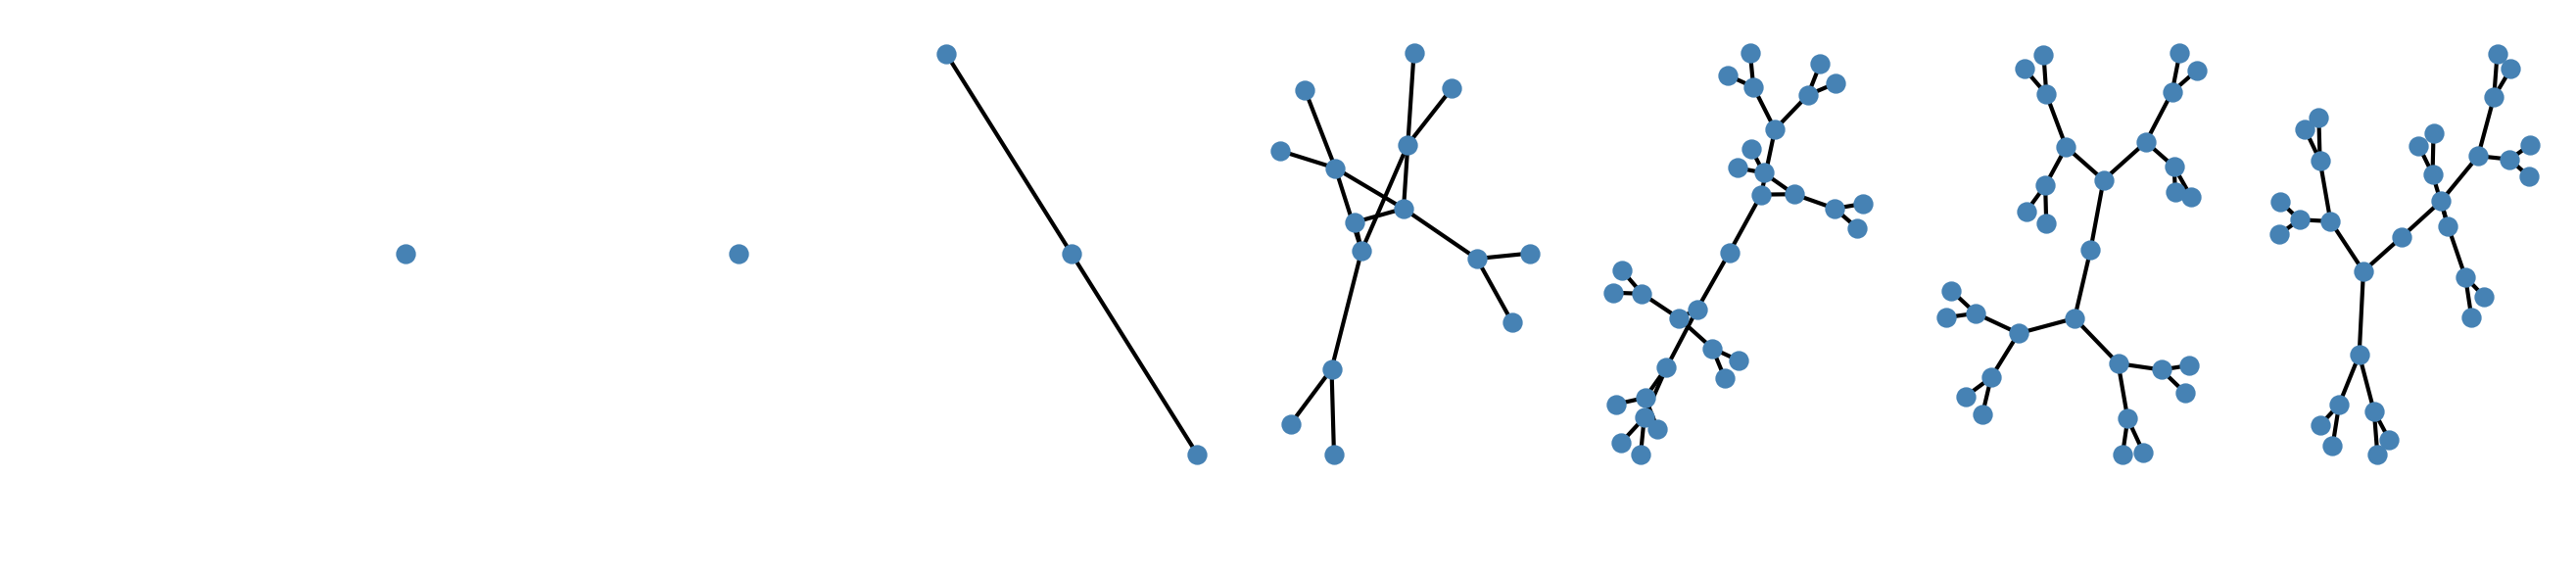

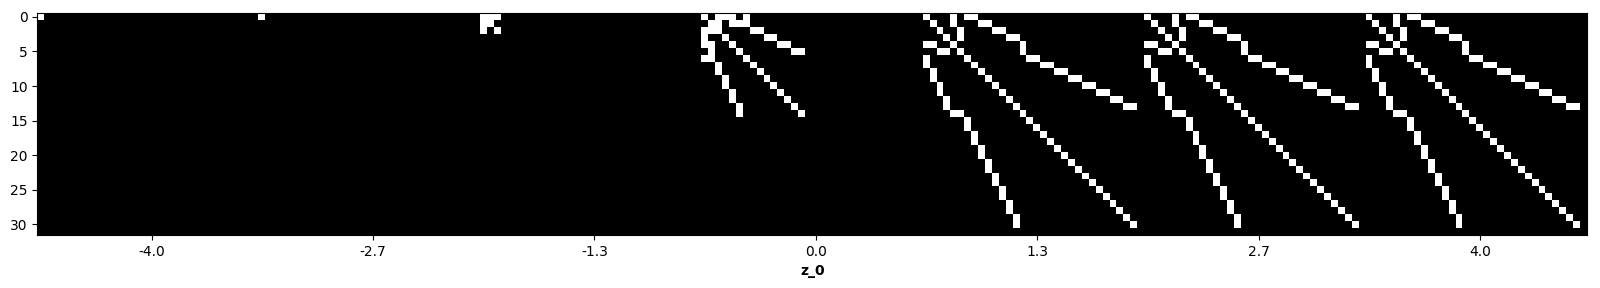

In [86]:
# range, normal, z
analyzeArgs = {"z": [0,1], "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 7, "save_plots": False}
generate_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

## Analyze Parameter Encoding

latent dimensions: 1


NameError: name 'b' is not defined

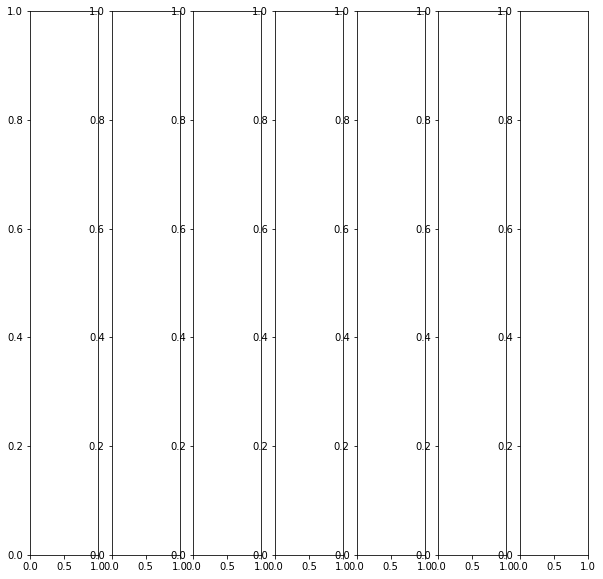

In [77]:
## range, normal, z
analyzeArgs = {"z": [0,1], "graph_type": "Tree", "sample": "range", "act_range": [-1.5, 2], "act_scale": 1, "size_of_manifold": 7, "save_plots": False}
generate_param_graph_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, trainArgs["batch_size"], scaler)

## "cluster_coef", "assort", "avg_degree"

latent dimensions: 1


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

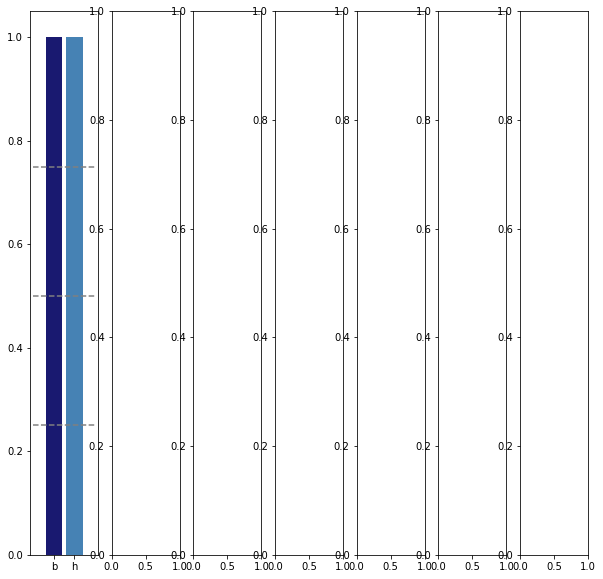

In [56]:
generate_param_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, trainArgs["batch_size"], scaler)